In [1]:
pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
!git clone https://github.com/prabaey/SynSUM.git

Cloning into 'SynSUM'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 218 (delta 8), reused 7 (delta 4), pack-reused 202 (from 2)
Receiving objects: 100% (218/218), 457.50 MiB | 35.80 MiB/s, done.
Resolving deltas: 100% (84/84), done.
Updating files: 100% (44/44), done.


In [3]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

In [4]:
def convert(df):
    mapping = {
        "yes": 1, "no": 0,
        "high": 2, "low": 1, "none": 0
    }
    
    for col in df.iloc[:, :12].columns:
        df[col] = df[col].map(mapping).fillna(df[col])  # Giữ nguyên giá trị nếu không có trong mapping
    
    return df

In [5]:
cols_to_drop = ['text', 'advanced_text', 'policy', 'antibiotics', 'self_empl', 'days_at_home']

### File train 8k
train_df = pd.read_pickle('/kaggle/input/diagnosis-of-pneumonia/concatenated_dataFileP.p')
train_df = train_df.drop(columns=cols_to_drop, errors='ignore')  

test_df = pd.read_pickle('/kaggle/working/SynSUM/data/emb/df_test_emb.p')
test_df = test_df.drop(columns=cols_to_drop, errors='ignore')  
#val_df = pd.read_pickle('/kaggle/working/SynSUM/data/emb/df_test_emb.p').drop(columns=cols_to_drop, errors='ignore')

train_df = convert(train_df)
test_df = convert(test_df)
#val_df = convert(val_df)
# Tạo nhãn kết hợp từ hai cột pneu và cold
count_values = train_df[['pneu', 'inf']].astype(str).agg('-'.join, axis=1)

# Kiểm tra số lượng mẫu mỗi nhóm nhãn
print(count_values.value_counts())

# Chia train/test với stratify theo nhãn mới
#train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


0-0    6057
0-1    1856
1-0      56
1-1      31
Name: count, dtype: int64


In [6]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

#background: season, policy, self-empl
#diagnosis: pneu, cold
#underlying condition: asthma, smoking, COPD
#symptoms: dyspnea, cough, pain, fever, nasal

BN = BayesianNetwork([
    ('smoking', 'COPD'),
    ('smoking', 'cough'),
    ('smoking', 'dysp'),
    ('asthma', 'dysp'),
    ('asthma', 'pneu'),
    ('asthma', 'cough'),
    ('hay_fever', 'dysp'),
    ('hay_fever', 'nasal'),
    ('COPD', 'pneu'),
    ('COPD', 'dysp'),
    ('COPD', 'cough'),
    ('COPD', 'pain'),
    ('winter', 'pneu'),
    ('winter', 'inf'),
    ('pneu', 'dysp'),
    ('pneu', 'cough'),
    ('pneu', 'pain'),
    ('pneu', 'fever'),
    ('inf', 'cough'),
    ('inf', 'pain'),
    ('pneu', 'fever'),
    ('pneu', 'nasal'),
    ('cough', 'pain'),
    #('policy','antibiotics'),
    #('self_empl','days_at_home')
])

def BN_model_train(train_df, test_df, target):
    print(f"🔹 Đang chạy với target: {target}")

    # Chuyển đổi nhãn thành 0 và 1
    train_df[target] = train_df[target]
    test_df[target] = test_df[target]

    # Huấn luyện mô hình
    BN.fit(train_df, estimator=BayesianEstimator)

    # Khởi tạo suy diễn
    inference = VariableElimination(BN)

    # Dự đoán trên tập test
    test_features = test_df.drop(columns=[target])
    y_true = test_df[target].values
    y_pred = np.array([
        inference.query(variables=[target], evidence=row.to_dict()).values[1]  
        for _, row in test_features.iterrows()
    ])

    # Tính ROC và PR Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    # Vẽ đồ thị
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Train ROC Curve for " + target)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for " + target)
    plt.legend()
    
    plt.show()

    return BN

In [7]:
from sklearn.svm import SVC
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


def SVM_model_train(symt, df_train, df_test, emb='hist_emb'):
    """
    Huấn luyện mô hình SVM cho một triệu chứng cụ thể.

    Args:
        symt (str): Tên triệu chứng cần huấn luyện.
        df_train (DataFrame): Tập huấn luyện.
        df_test (DataFrame): Tập kiểm tra.
        emb (str): Tên cột chứa embeddings (mặc định là 'hist_emb').

    Returns:
        Tuple: (precision, recall, f1, accuracy), model đã huấn luyện.
    """
    # Chuyển embeddings từ dạng list thành numpy array
    X_train = np.array(df_train[emb].tolist())
    X_test = np.array(df_test[emb].tolist())

    # Xử lý nhãn
    y_train = df_train[symt].values
    y_test = df_test[symt].values

    # Xác định số lớp
    num_classes = len(np.unique(y_train))
    is_multiclass = num_classes > 2

    # Định nghĩa mô hình SVM
    model = SVC(
        kernel='rbf',
        C=1.0,
        probability=True,
        class_weight='balanced' if is_multiclass else None,
        random_state=42
    )

    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)

    # Tính độ đo đánh giá
    average_type = 'weighted' if is_multiclass else 'binary'
    precision = precision_score(y_test, y_pred, average=average_type)
    recall = recall_score(y_test, y_pred, average=average_type)
    f1 = f1_score(y_test, y_pred, average=average_type)
    accuracy = accuracy_score(y_test, y_pred)

    scores = [precision, recall, f1, accuracy]
    return scores, model

In [8]:
def test_SVM(SVM_models, test_df, emb='hist_emb'):
    """
    Kiểm tra mô hình bằng cách chạy tập test qua 5 mô hình SVM riêng biệt.

    Args:
        SVM_models: Dictionary chứa 5 mô hình SVM cho từng triệu chứng.
        test_df: DataFrame chứa tập test, phải có cột 'emb'.
        emb: Tên cột chứa embedding.

    Returns:
        feature_df: DataFrame chứa đặc trưng từ mô hình.
    """
    # Kiểm tra embeddings
    if emb not in test_df:
        raise ValueError(f"Lỗi: Không tìm thấy cột '{emb}' trong test_df!")

    test_df = test_df.dropna(subset=[emb]).reset_index()  # Lưu lại index gốc
    original_index = test_df['index']

    X_test = np.array(test_df[emb].tolist())  # Chuyển Series thành numpy array
    if X_test.ndim == 1:
        X_test = np.expand_dims(X_test, axis=1)  # Đảm bảo shape (N, D)

    # Trích xuất đặc trưng từ các mô hình SVM
    symptoms = ["dysp", "cough", "pain", "fever", "nasal"]
    predictions = {}

    for symptom in symptoms:
        model = SVM_models.get(symptom, None)
        if model is None:
            raise ValueError(f"Lỗi: Không tìm thấy mô hình cho triệu chứng '{symptom}'!")

        pred = model.predict(X_test)
        pred = pred.flatten()
        predictions[symptom] = pd.Series(pred, index=test_df.index)

    # Chuyển kết quả dự đoán thành DataFrame
    feature_df = pd.DataFrame(predictions)

    # Ghép với đặc trưng nền từ test_df
    X_background = test_df.iloc[:, :8].drop(columns=['index'], errors='ignore')
    feature_df = pd.concat([X_background, feature_df], axis=1)
    
    return feature_df
    
def test_BN(feature_df, BN_model):
    # Bước 5: Suy diễn Bayes
    inference = VariableElimination(BN_model)

    def convert_to_class(symptom, value):
        if symptom == "fever":
            return np.argmax(value)  # Lấy nhãn có xác suất cao nhất
        return int(value >= 0.5)  # Với triệu chứng nhị phân

    def bayes_inference(row):
        evidence = row.to_dict()

        # Chuyển đổi từng giá trị trong `evidence`
        for key in evidence.keys():
            evidence[key] = convert_to_class(key, evidence[key])

        # Xóa target khỏi evidence (tránh lỗi trùng lặp)
        if target in evidence:
            del evidence[target]

        # Truy vấn xác suất
        query_result = inference.query(variables=[target], evidence=evidence)

        # Trả về xác suất của lớp 1 (positive class)
        return query_result.values[1]  # Xác suất target = 1


    print("Nodes in Bayesian Network:", BN_model.nodes())
    print("Columns in test_features:", feature_df.columns.tolist())

    # Bước 6: Dự đoán
    y_true = test_df[target].values
    y_pred = feature_df.apply(bayes_inference, axis=1)

    # Bước 7: Tính ROC và PR Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    # Bước 8: Vẽ đồ thị
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Test ROC Curve for " + target)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for " + target)
    plt.legend()
    
    plt.show()

    return y_pred, y_true

🔹 Đang chạy với target: pneu


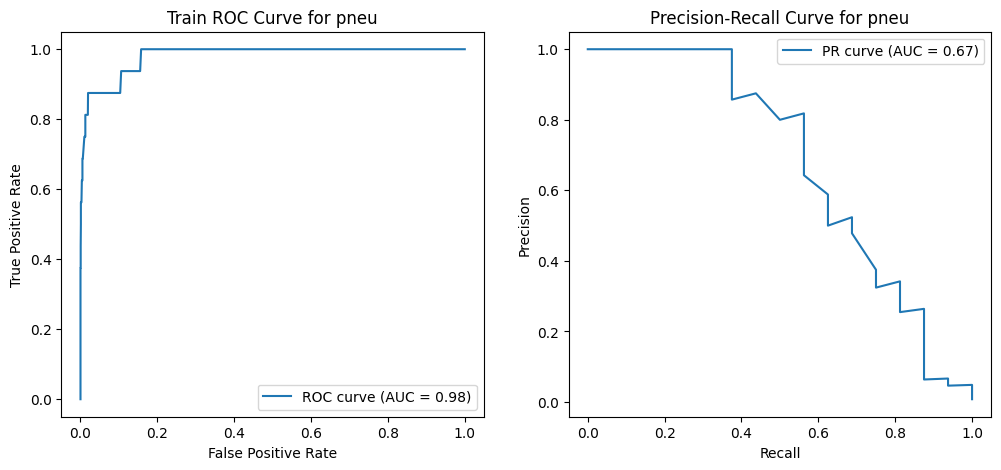

🔹 Đang chạy với target: inf


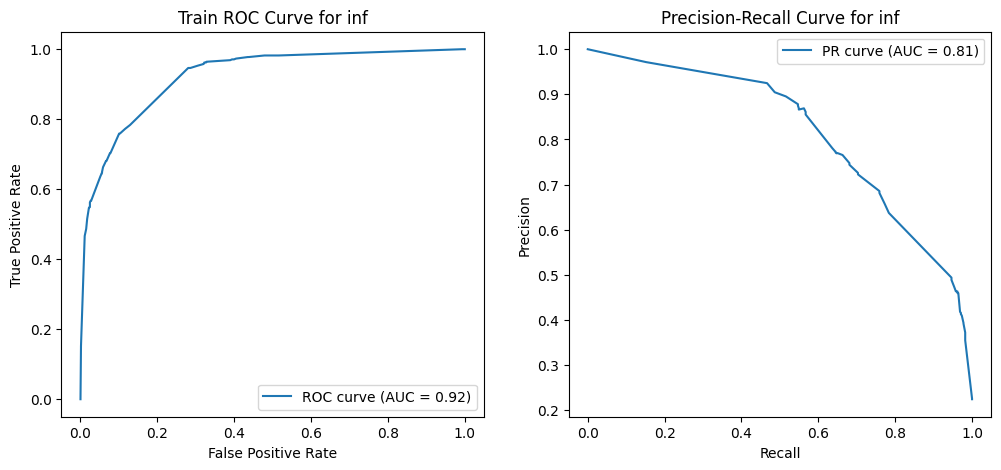

In [9]:
### TRAIN Text for 5 symps
symptoms = ["dysp", "cough", "pain", "fever", "nasal"]

result = pd.DataFrame(columns=["precision", "recall", "f1", "accuracy"])
SVM_models = {}

for i in symptoms:
    metrics, model = SVM_model_train(i, train_df, test_df)  # Đảm bảo NN_model_train trả về tuple
    result.loc[len(result)] = metrics  # Gán giá trị metrics vào hàng mới
    SVM_models[i] = model  # Lưu mô hình vào dictionary
    
### TRAIN BN for pneu/inf
targets = ["pneu", "inf"]
BN_models = {
    'pneu': BN_model_train(train_df.iloc[:, :12], test_df.iloc[:, :12], "pneu"),
    'inf': BN_model_train(train_df.iloc[:, :12], test_df.iloc[:, :12], "inf")
}

Nodes in Bayesian Network: ['smoking', 'COPD', 'cough', 'dysp', 'asthma', 'pneu', 'hay_fever', 'nasal', 'pain', 'winter', 'inf', 'fever']
Columns in test_features: ['asthma', 'smoking', 'COPD', 'winter', 'hay_fever', 'inf', 'dysp', 'cough', 'pain', 'fever', 'nasal']


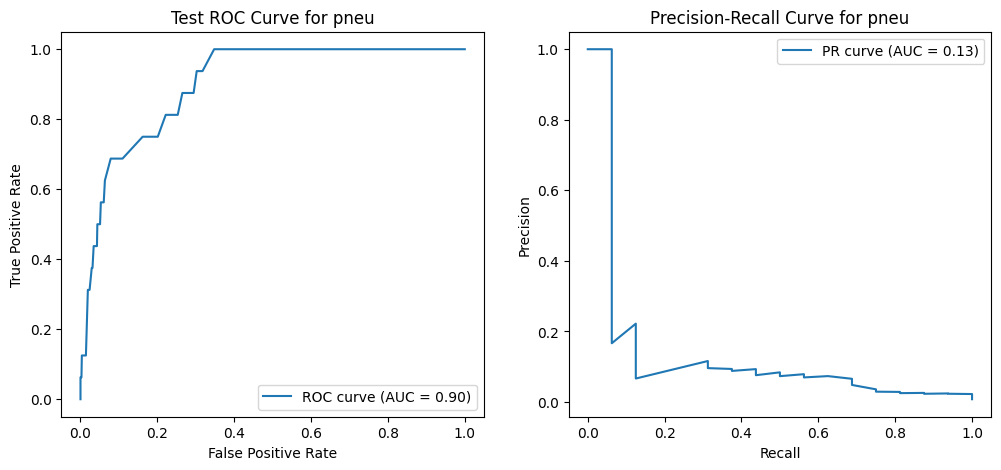

Nodes in Bayesian Network: ['smoking', 'COPD', 'cough', 'dysp', 'asthma', 'pneu', 'hay_fever', 'nasal', 'pain', 'winter', 'inf', 'fever']
Columns in test_features: ['asthma', 'smoking', 'COPD', 'winter', 'hay_fever', 'pneu', 'dysp', 'cough', 'pain', 'fever', 'nasal']


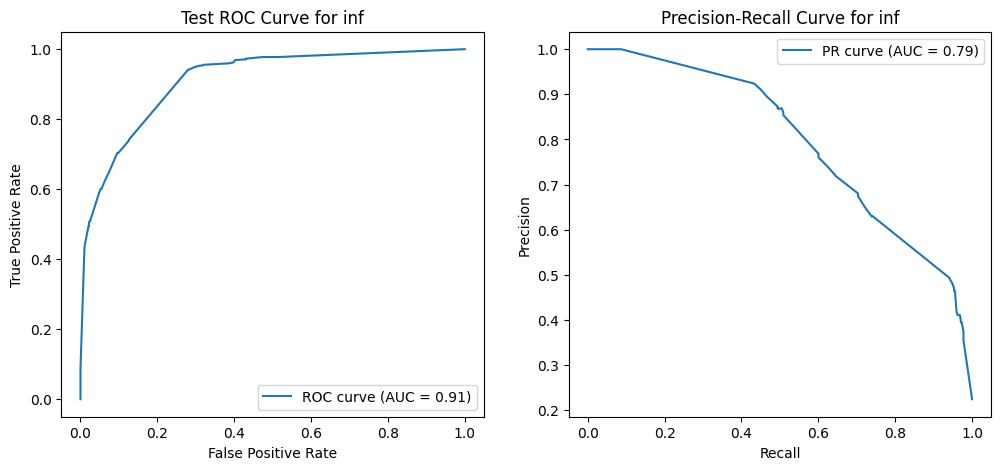

In [10]:
### TEST text -> symps -> target
feature_df = test_SVM(SVM_models, test_df, emb='hist_emb')
for target in targets:
    y_pred = test_BN(feature_df.drop(columns=[target], errors='ignore'), BN_models[target])

In [11]:
print("Result for symps")
result

Result for symps


,precision,recall,f1,accuracy
0,0.978780,0.924812,0.951031,0.9810
1,0.984472,0.946269,0.964992,0.9770
2,0.989189,0.648936,0.783726,0.9495
3,0.941641,0.943000,0.941757,0.9430
4,0.983368,0.923828,0.952669,0.9765
